# MUTATION CALLER COMPARISON in MELANOMA sample

In [4]:
# Needed basic packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib_venn import venn3

# 1/ Importing filtered mutation tables

In [2]:
import pandas as pd

# Import filtered mutation files 
mutect_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Mel_Mutect2_VAF.tsv.gz', sep="\t", header=0)
strelka_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Mel_Strelka_VAF_all.tsv.gz', sep="\t", header=0)
sage_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Mel_SAGE_VAF.tsv.gz', sep="\t", header=0)

In [3]:
mutect_df.shape + strelka_df.shape + sage_df.shape

(1079488, 22, 1279052, 20, 1013333, 22)

In [5]:
sage_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_AF,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,mut_type,SAMPLE
0,chr1,59074,.,C,T,254,PASS,RC=ATTTTTTG;RC_IDX=4;RC_LF=TTCATCAAGT;RC_NM=1;...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:69,0:0:69:2230,0:74,0:0,0,0,0,0,69,69:0:...",...,0.0,55,69,39,69,16,0,0.291,SNV,melanoma
1,chr1,108632,.,C,T,282,PASS,RC=ATTCCCCA;RC_IDX=2;RC_LF=AGGTGAACAT;RC_NM=1;...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:176,0:0:176:5404,0:178,0:0,0,0,0,0,176,1...",...,0.0,178,176,154,176,24,0,0.135,SNV,melanoma
2,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:155,0:0:155:4877,0:159,0:0,0,0,0,0,155,1...",...,0.0,157,155,134,155,22,0,0.140,SNV,melanoma
3,chr1,135156,.,G,A,307,PASS,RC=GAAAG;RC_IDX=2;RC_LF=GCTGGGCGTG;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:246,0:0:246:7687,0:250,0:0,0,0,0,0,246,2...",...,0.0,232,246,213,246,19,0,0.082,SNV,melanoma
4,chr1,182978,.,GG,AA,451,PASS,LPS=5;LPS_RC=27;RC=GTAAGA;RC_IDX=2;RC_LF=ATTGG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:182,0:0:182:5653,0:184,0:0,0,0,0,0,182,1...",...,0.0,207,182,180,182,27,0,0.130,MNV,melanoma


## a) Find the number of common mutations with the callers

In [6]:
#Add a new column in mutect/strelka tables joining the CHROM-POS-REF-ALT information and extract it as a list

mutect_df['mut'] = mutect_df.apply(lambda row: row['CHROM']+'_'+str(row['POS'])+'_'+row['REF']+'_'+row['ALT'],axis=1)
m_list = mutect_df['mut'].tolist()

strelka_df['mut'] = strelka_df.apply(lambda row: row['CHROM']+'_'+str(row['POS'])+'_'+row['REF']+'_'+row['ALT'],axis=1)
s_list = strelka_df['mut'].tolist()

sage_df['mut'] = sage_df.apply(lambda row: row['CHROM']+'_'+str(row['POS'])+'_'+row['REF']+'_'+row['ALT'],axis=1)
sage_list = sage_df['mut'].tolist()

# Convert to a set function to obtain a unique collection of elements
set_m = set(m_list)
set_s = set(s_list)
set_sage = set(sage_list)

In [7]:
# Check if number of mutations coincides with previous data
# len(set_m)
# len(set_s)
len(set_sage)

1013333

Text(0.5, 1.0, 'Melanoma mutations')

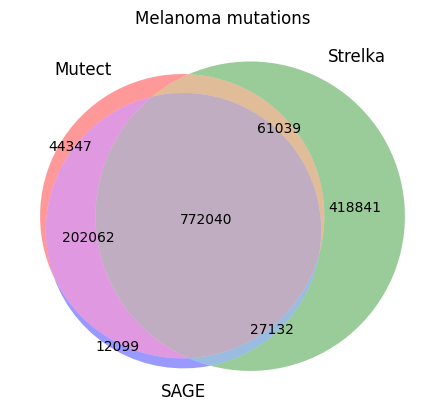

In [8]:
venn3([set_m,set_s, set_sage],set_labels=['Mutect','Strelka','SAGE'])
plt.title('Melanoma mutations')

# Sum numbers specific of each circle to check if the dimensions plotted agree with the number of mutations of each caller

## b) Obtain the list of mutations in a minimum of 2 callers

In [9]:
# Now merge based on "mut" column, in two-by-two comparisons since we want the common mutations in a minimum of two callers (how=inner)
mutstr_common_df = pd.merge(mutect_df, strelka_df, how ="inner", on=['mut'], suffixes=['_Mut','_Str'], indicator = True)
mutsage_common_df = pd.merge(mutect_df, sage_df, how ="inner", on=['mut'], suffixes=['_Mut','_SAGE'], indicator = True)
strsage_common_df = pd.merge(strelka_df, sage_df, how ="inner", on=['mut'], suffixes=['_Str','_SAGE'], indicator = True)

# Now we have the common mutations between callers.
# Since we priorize information from SAGE > Mutect2 callers, we will delete all information from the caller (Strelka information is not considered in any case)
mutstr_common_df = mutstr_common_df.loc[:, ~mutstr_common_df.columns.str.endswith('_Str')] # here we delete columns from Strelka and remain Mutect2 columns
mutsage_common_df = mutsage_common_df.loc[:, ~mutsage_common_df.columns.str.endswith('_Mut')] # here we delete columns from mutect and remain SAGE columns
strsage_common_df = strsage_common_df.loc[:, ~strsage_common_df.columns.str.endswith('_Str')] # here we delete columns from Strelka and remain SAGE columns

In [10]:
strsage_common_df

,Mut_type,mut,CHROM_SAGE,POS_SAGE,ID_SAGE,REF_SAGE,ALT_SAGE,QUAL_SAGE,FILTER_SAGE,INFO_SAGE,...,t_DP_SAGE,n_DP_SAGE,t_ref_reads_SAGE,n_ref_reads_SAGE,t_alt_reads_SAGE,n_alt_reads_SAGE,VAF_SAGE,mut_type,SAMPLE_SAGE,_merge
0,SNV,chr1_59074_C_T,chr1,59074,.,C,T,254,PASS,RC=ATTTTTTG;RC_IDX=4;RC_LF=TTCATCAAGT;RC_NM=1;...,...,55,69,39,69,16,0,0.291,SNV,melanoma,both
1,SNV,chr1_108632_C_T,chr1,108632,.,C,T,282,PASS,RC=ATTCCCCA;RC_IDX=2;RC_LF=AGGTGAACAT;RC_NM=1;...,...,178,176,154,176,24,0,0.135,SNV,melanoma,both
2,SNV,chr1_115638_G_A,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,...,157,155,134,155,22,0,0.140,SNV,melanoma,both
3,SNV,chr1_608567_G_A,chr1,608567,.,G,A,261,PASS,RC=GAAGGGGC;RC_IDX=2;RC_LF=ACCAAGAACC;RC_NM=1;...,...,123,128,106,128,17,0,0.138,SNV,melanoma,both
4,SNV,chr1_631750_G_A,chr1,631750,.,G,A,393,PASS,LPS=3;LPS_RC=2;RC=CGGAGGAGAAGA;RC_IDX=8;RC_LF=...,...,108,110,91,110,17,0,0.157,SNV,melanoma,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799167,INDEL,chrX_142969323_GA_G,chrX,142969323,.,GA,G,259,PASS,RC=AAGCT;RC_IDX=2;RC_LF=AAAATGTAGA;RC_NM=1;RC_...,...,63,70,47,70,16,0,0.254,INDEL,melanoma,both
799168,INDEL,chrX_144907743_GA_G,chrX,144907743,.,GA,G,256,PASS,MH=A;RC=GGGAAAGT;RC_IDX=2;RC_LF=CTAAGCCAAA;RC_...,...,57,55,43,55,14,0,0.246,INDEL,melanoma,both
799169,INDEL,chrX_149273239_TC_T,chrX,149273239,.,TC,T,268,PASS,LPS=427131;LPS_RC=16;RC=GTTTTTTTTTC;RC_IDX=3;R...,...,59,82,43,82,16,0,0.271,INDEL,melanoma,both
799170,INDEL,chrY_12603286_GC_G,chrY,12603286,.,GC,G,265,PASS,LPS=427905;LPS_RC=14;MH=C;RC=CTGCTTGC;RC_IDX=2...,...,62,85,47,85,15,0,0.242,INDEL,melanoma,both


In [11]:
# Now merge the three callers to obtain those mutations that are shared by all of them
mutstrsage_common_df = pd.merge(mutstr_common_df, sage_df, how ="inner", on=['mut'], suffixes=['_MutStr','_SAGE'])
mutstrsage_common_df = mutstrsage_common_df.loc[:, ~mutstrsage_common_df.columns.str.endswith('_MutStr')] # here we delete columns from Mutect2-Strelka and remain SAGE columns

In [12]:
mutstrsage_common_df.head()

,CHROM_Mut,POS_Mut,ID_Mut,REF_Mut,ALT_Mut,QUAL_Mut,FILTER_Mut,INFO_Mut,FORMAT_Mut,NORMAL_Mut,...,n_AF_SAGE,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,mut_type_SAGE,SAMPLE
0,chr1,59074,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=48,39|5,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:69,0:0.014:69:25,0:38,0:67,0:36,33,0,0",...,0.0,55,69,39,69,16,0,0.291,SNV,melanoma
1,chr1,108632,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=134,78|7,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.495e-03:153:74,0:73,0:151,0:104,49...",...,0.0,178,176,154,176,24,0,0.135,SNV,melanoma
2,chr1,608567,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,72|7,4;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:131,0:7.558e-03:131:69,0:59,0:129,0:76,55,0,0",...,0.0,123,128,106,128,17,0,0.138,SNV,melanoma
3,chr1,631750,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=108,101|12,6;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:116,0:8.473e-03:116:59,0:53,0:114,0:59,57,0,0",...,0.0,108,110,91,110,17,0,0.157,SNV,melanoma
4,chr1,633851,.,A,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,95|8,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:115,0:8.652e-03:115:67,0:40,0:111,0:65,50,0,0",...,0.0,111,115,97,115,14,0,0.126,SNV,melanoma


In [13]:
# Add Caller intersection name as a column
mutstr_common_df = mutstr_common_df.assign(Caller_intersec='Mutect_Strelka')
mutsage_common_df = mutsage_common_df.assign(Caller_intersec='Mutect_SAGE')
strsage_common_df = strsage_common_df.assign(Caller_intersec='Strelka_SAGE')
mutstrsage_common_df = strsage_common_df.assign(Caller_intersec='Mutect_Strelka_SAGE')

In [14]:
for col in mutstr_common_df.columns:
    print(col)

CHROM_Mut
POS_Mut
ID_Mut
REF_Mut
ALT_Mut
QUAL_Mut
FILTER_Mut
INFO_Mut
FORMAT_Mut
NORMAL_Mut
TUMOR_Mut
t_AF
n_AF
t_DP_Mut
n_DP_Mut
t_ref_reads_Mut
n_ref_reads_Mut
t_alt_reads_Mut
n_alt_reads_Mut
VAF_Mut
mut_type
SAMPLE_Mut
mut
Mut_type
_merge
Caller_intersec


In [15]:
# Define a custom function to remove the indexes from columns
def remove_colindex(column):
    return column.replace('_Mut', '')

def remove_colindex2(column):
    return column.replace('_SAGE', '')

# Apply the custom function to the date column names using a list comprehension
mutstr_common_df.columns = [remove_colindex(col) for col in mutstr_common_df.columns]
mutsage_common_df.columns = [remove_colindex2(col) for col in mutsage_common_df.columns]
strsage_common_df.columns = [remove_colindex2(col) for col in strsage_common_df.columns]
mutstrsage_common_df.columns = [remove_colindex2(col) for col in mutstrsage_common_df.columns]

In [16]:
# Now that each intersection is controlled in a column, reorder and rename all the other columns prior to merge 

# Reorder columns according to a list with the same column names
cols = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'NORMAL', 'TUMOR','t_AF', 'n_AF', 't_DP','n_DP','t_alt_reads', 'n_alt_reads', 't_ref_reads','n_ref_reads', 'VAF', 'mut_type', 'Caller_intersec', 'SAMPLE','mut']

mutstr_common_df = mutstr_common_df.reindex(cols, axis = 1)
strsage_common_df = strsage_common_df.reindex(cols, axis = 1)
mutsage_common_df = mutsage_common_df.reindex(cols, axis = 1)
strsage_common_df = strsage_common_df.reindex(cols, axis = 1)
mutstrsage_common_df = mutstrsage_common_df.reindex(cols, axis = 1)

In [17]:
# Check column order of each dataframe: 
for col in mutstrsage_common_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_AF
n_AF
t_DP
n_DP
t_alt_reads
n_alt_reads
t_ref_reads
n_ref_reads
VAF
mut_type
Caller_intersec
SAMPLE
mut


In [18]:
# Join the list of common mutations again (keep in mind some of them will be repeated!)

final_mutations_df = pd.concat([mutstr_common_df, mutsage_common_df,strsage_common_df,mutstrsage_common_df], ignore_index=True) # ignore index omits the index number of each row in the original table

# # Now convert it into a dataframe
final_mutations_df = pd.DataFrame(final_mutations_df) 
len(final_mutations_df) # see that some values are repeated!

# Use drop duplicates pandas function to exclude repeated values based on 'mut' column
final_mutations_df = final_mutations_df.drop_duplicates(subset=['mut'])
len(final_mutations_df)

final_mutations_df.tail()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
2606310,chrX,85920102,.,A,AT,221,PASS,LPS=422949;LPS_RC=12;MH=T;RC=TTATTTTTTTTTTTTAA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:55,0:0:55:1851,0:61,0:0,0,0,0,0,55,55:0:...",...,55,12,0,33,55,0.261,INDEL,Strelka_SAGE,melanoma,chrX_85920102_A_AT
2606311,chrX,86443504,.,AT,A,183,PASS,MH=T;RC=GAATTTTTTTTTTTTTTCT;RC_IDX=2;RC_LF=CAA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:54,0:0:54:1874,0:60,0:0,0,0,0,0,54,54:0:...",...,54,16,0,35,54,0.314,INDEL,Strelka_SAGE,melanoma,chrX_86443504_AT_A
2606326,chrX,110465687,.,CCA,C,179,PASS,LPS=424519;LPS_RC=10;RC=GACAAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:68,0:0:68:2119,0:72,0:0,0,0,0,0,68,68:0:...",...,68,10,0,48,68,0.172,INDEL,Strelka_SAGE,melanoma,chrX_110465687_CCA_C
2606338,chrX,127393526,.,TA,T,163,PASS,MH=A;RC=AATAAAAAAAAAAAACA;RC_IDX=2;RC_LF=CATTT...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:53,0:0:54:1805,0:58,0:0,0,0,0,0,53,54:0:...",...,54,15,0,44,53,0.254,INDEL,Strelka_SAGE,melanoma,chrX_127393526_TA_T
2606346,chrX,140951316,.,C,CA,193,PASS,MH=A;RC=TTCAAAAAAAAAAAAAAAAAT;RC_IDX=2;RC_LF=A...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:50,0:0:51:1795,0:62,0:0,0,0,0,0,50,51:0:...",...,51,18,0,45,50,0.286,INDEL,Strelka_SAGE,melanoma,chrX_140951316_C_CA


In [19]:
final_mutations_df.tail()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
2606310,chrX,85920102,.,A,AT,221,PASS,LPS=422949;LPS_RC=12;MH=T;RC=TTATTTTTTTTTTTTAA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:55,0:0:55:1851,0:61,0:0,0,0,0,0,55,55:0:...",...,55,12,0,33,55,0.261,INDEL,Strelka_SAGE,melanoma,chrX_85920102_A_AT
2606311,chrX,86443504,.,AT,A,183,PASS,MH=T;RC=GAATTTTTTTTTTTTTTCT;RC_IDX=2;RC_LF=CAA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:54,0:0:54:1874,0:60,0:0,0,0,0,0,54,54:0:...",...,54,16,0,35,54,0.314,INDEL,Strelka_SAGE,melanoma,chrX_86443504_AT_A
2606326,chrX,110465687,.,CCA,C,179,PASS,LPS=424519;LPS_RC=10;RC=GACAAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:68,0:0:68:2119,0:72,0:0,0,0,0,0,68,68:0:...",...,68,10,0,48,68,0.172,INDEL,Strelka_SAGE,melanoma,chrX_110465687_CCA_C
2606338,chrX,127393526,.,TA,T,163,PASS,MH=A;RC=AATAAAAAAAAAAAACA;RC_IDX=2;RC_LF=CATTT...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:53,0:0:54:1805,0:58,0:0,0,0,0,0,53,54:0:...",...,54,15,0,44,53,0.254,INDEL,Strelka_SAGE,melanoma,chrX_127393526_TA_T
2606346,chrX,140951316,.,C,CA,193,PASS,MH=A;RC=TTCAAAAAAAAAAAAAAAAAT;RC_IDX=2;RC_LF=A...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:50,0:0:51:1795,0:62,0:0,0,0,0,0,50,51:0:...",...,51,18,0,45,50,0.286,INDEL,Strelka_SAGE,melanoma,chrX_140951316_C_CA


In [20]:
# 1/ First reorder by chromosomes then by position in CHROM and POS columns

# Define a list to order by chromosomes
chrom = ['chr1','chr2','chr3','chr4','chr5','chr6', 'chr7', 'chr8', 'chr9', 'chr10','chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chr23', 'chrX', 'chrY']

# Create a categorical variable for chromosomes
final_mutations_df['CHROM'] = pd.Categorical(final_mutations_df['CHROM'], categories=chrom, ordered=True) # in categories we indicate the order

final_mutations_df = final_mutations_df.sort_values(by=['CHROM','POS']) # it will reorder based on CHROM and POS

final_mutations_df.reset_index(drop=True, inplace=True) # Reset indexes

In [21]:
final_mutations_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
0,chr1,59074,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=48,39|5,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:69,0:0.014:69:25,0:38,0:67,0:36,33,0,0",...,69,11,0,18,69,0.379310,SNV,Mutect_Strelka,melanoma,chr1_59074_C_T
1,chr1,60739,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=46,55|4,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:65,0:0.015:65:32,0:30,0:65,0:28,37,0,0",...,65,10,0,36,65,0.217391,SNV,Mutect_Strelka,melanoma,chr1_60739_G_A
2,chr1,86292,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,106|6,4;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:106,0:9.164e-03:106:46,0:41,0:106,0:43,63,0,0",...,106,10,0,75,106,0.117647,SNV,Mutect_Strelka,melanoma,chr1_86292_C_T
3,chr1,108632,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=134,78|7,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.495e-03:153:74,0:73,0:151,0:104,49...",...,153,13,0,59,153,0.180556,SNV,Mutect_Strelka,melanoma,chr1_108632_C_T
4,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:155,0:0:155:4877,0:159,0:0,0,0,0,0,155,1...",...,155,22,0,134,155,0.140000,SNV,Strelka_SAGE,melanoma,chr1_115638_G_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062268,chrY,56824933,.,C,T,293,PASS,LPS=428319;LPS_RC=9;RC=TCTTTA;RC_IDX=2;RC_LF=T...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:518,0:0:518:16364,0:539,0:0,0,0,0,0,518,...",...,518,16,0,399,518,0.039000,SNV,Mutect_SAGE,melanoma,chrY_56824933_C_T
1062269,chrY,56825646,.,G,A,454,PASS,LPS=428320;LPS_RC=4;RC=GAAAGC;RC_IDX=3;RC_LF=A...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:430,0:0:430:13675,0:443,0:0,0,0,0,0,430,...",...,430,16,0,362,430,0.042000,SNV,Mutect_SAGE,melanoma,chrY_56825646_G_A
1062270,chrY,56846085,.,C,T,558,PASS,RC=CTTTG;RC_IDX=2;RC_LF=TTTTTCTACC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:33:599,1:0.001667:600:18877,0:615,0:0,0,1,...",...,600,21,1,500,599,0.040000,SNV,Mutect_SAGE,melanoma,chrY_56846085_C_T
1062271,chrY,56846554,.,G,A,305,PASS,RC=AGATG;RC_IDX=2;RC_LF=CTGATCACAC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:9:662,1:0.001508:663:20164,9:683,1:1,0,0,0...",...,663,14,1,513,662,0.027000,SNV,Mutect_SAGE,melanoma,chrY_56846554_G_A


In [114]:
# Export tSV table
final_mutations_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Mel_List_common_mutations_callers.tsv.gz', sep ='\t', index=None, compression = "gzip")

### Histogram VAF common mutations

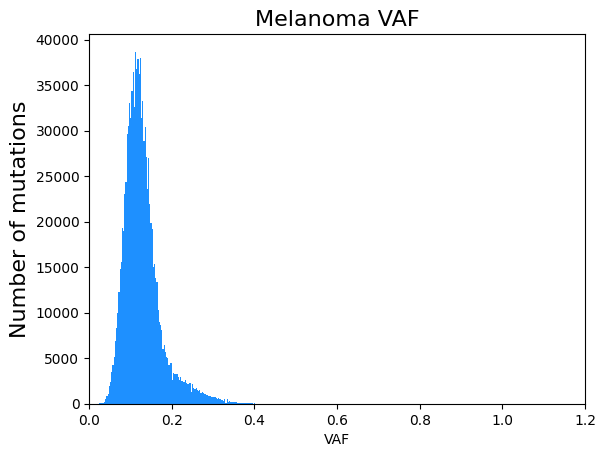

In [22]:
# VAF representation through histogram
plt.hist(final_mutations_df['VAF'].tolist(), bins = 200, color = "dodgerblue")
plt.ylabel('Number of mutations', fontsize=16, weight = bold)
plt.xlim([0,1.2]) 
plt.xlabel('VAF')
plt.title('Melanoma VAF', fontsize=16)
plt.show(final_mutations_df['VAF'].tolist()) 

### Change Graph language for master project

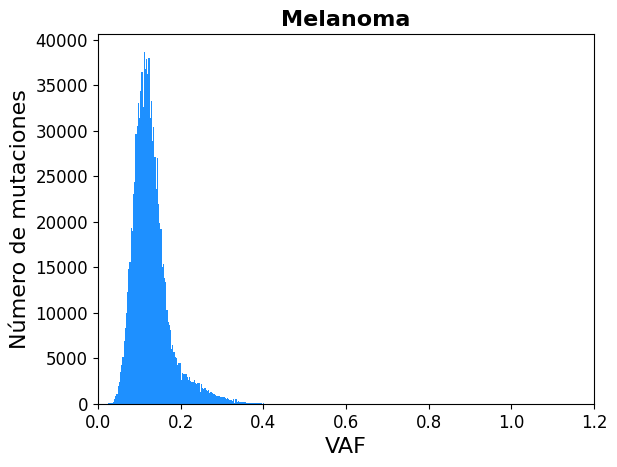

In [28]:
# VAF representation through histogram
plt.hist(final_mutations_df['VAF'].tolist(), bins = 200, color = "dodgerblue")
plt.ylabel('Número de mutaciones',fontsize=16)
plt.xlim([0,1.2]) 
plt.xlabel('VAF', fontsize=16)
plt.title('Melanoma', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show(final_mutations_df['VAF'].tolist()) 

# Export image to directory
# plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_melanoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')